### Edgar Moises Hernandez-Gonzalez
#### 21/02/20-07/05/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x8
##### 5 ejecuciones independientes

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 66.67%
##### Kappa = 0.5556

#### CNN-2D + LSTM BN
##### Sujeto 1
##### Accuracy = 52.08%
##### Kappa = 0.3611

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 60.42%
##### Kappa = 0.4722

#### CNN-2D + GRU BN
##### Sujeto 1
##### Accuracy = 55.21%
##### Kappa = 0.4028

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 63.19%
##### Kappa = 0.5093

#### ConvLSTM2D BN
##### Sujeto 1
##### Accuracy = 51.74%
##### Kappa = 0.3565

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense, Dropout)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [9]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (8, 264) #ancho, alto
  fs = 250
  datos = np.zeros((288,264,8))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [11]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

0
100
200
0
100
200


In [12]:
print(x_train.shape)
print(x_test.shape)

(288, 264, 8)
(288, 264, 8)


In [13]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

65.53692251223107
55.06980719402351
0.001085261144493673
0.00041804610564340585
1.1717788228684476
1.1858305338371293


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 66.0
x_test /= 66.0

In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99298376
0.83439106
1.644335e-05
6.334032e-06
0.017754223
0.017967127


In [16]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 1, 264, 8, 1)
(288, 1, 264, 8, 1)


In [0]:
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CNN2D_LSTM_STFT09.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def Conv_LSTM_2D_BN():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(8, activation='tanh', dropout=0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.9340450366338094
accuracy:  0.6111111044883728
kappa:  0.4814814814814815
confusion matrix:
 [[41 18  9  4]
 [14 46 12  0]
 [ 4  3 43 22]
 [ 5  2 19 46]]


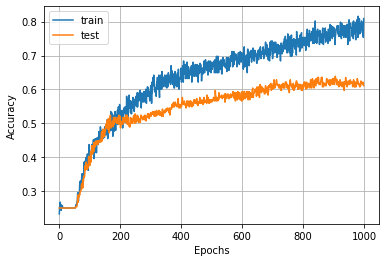

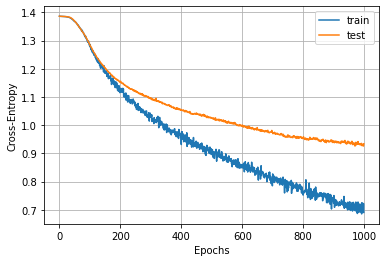

Iteration: 2
loss:  0.7829364273283217
accuracy:  0.6423611044883728
kappa:  0.5231481481481481
confusion matrix:
 [[50 14  7  1]
 [18 49  4  1]
 [ 3  1 37 31]
 [ 2  2 19 49]]


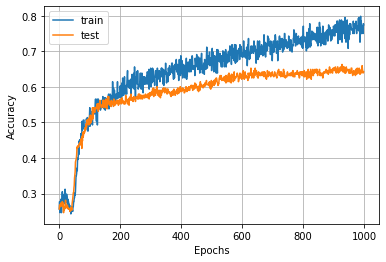

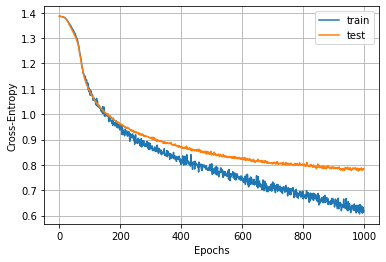


Resultados:
loss: [0.9340450366338094, 0.7829364273283217]
accuracy: [0.6111111044883728, 0.6423611044883728]
kappa: [0.4814814814814815, 0.5231481481481481]


In [19]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_2D_LSTM_TD()

  history = model.fit(x_train, y_train, epochs=1000, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
                      #callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 1, 264, 8, 128)    1280      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 132, 4, 128)    0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 1, 132, 4, 128)    147584    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 1, 66, 2, 128)     0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 1, 66, 2, 128)     147584    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 1, 16896)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                

In [21]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6267
std: (+/- 0.0156)
Mean Kappa: 0.5023
std: (+/- 0.0208)
Max Accuracy: 0.6424
Max Kappa: 0.5231
